In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples
from dynesty import NestedSampler

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def salt2_model_like_sig_par(self,theta):
        Om, Ol, M, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
        
        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=np.sqrt(0.0012**2+self.data["zerr"]**2)*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        #print(sigma2.values)
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike

    def log_prior_sig_par(self, theta):
        Om, Ol, M, alpha, beta, sigma=theta     

        if not (0. < Om < 1. and -0.5 < Ol < 1.5 and 20. < M < 26. and 0. < alpha < 0.5 and 1. < beta < 3. and 0. < sigma < 0.5):
            return -np.inf
        return 0. 
    
    def log_probability_salt2_like_sig_par(self,theta):
        lp = self.log_prior_sig_par(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model_like_sig_par(theta)


## Carregando dados

In [3]:
dat=pd.read_csv("SALT2.FITRES",sep="\s+")

In [4]:
cov_mB_x1=-2.5*np.log10(np.e)/dat["x0"]*dat["covx0x1"]
cov_mB_c=-2.5*np.log10(np.e)/dat["x0"]*dat["covx0c"]

In [5]:
data=dat[["Z","ZERR","mb","mberr","x1","x1err","c","cerr","covx1c"]]

In [6]:
data.insert(9, "cov_mB_x1",cov_mB_x1, True)
data.insert(10, "cov_mB_c",cov_mB_c, True)

In [7]:
data.columns=["z","zerr","mB","mBerr","x1","x1err","c","cerr","cov_x1_c","cov_mB_x1","cov_mB_c"]

In [8]:
data=data.dropna().reset_index(drop=True)

In [9]:
cosmo_salt2=cosmo(data)

In [12]:
def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    #om ol M a b s
    
    x = np.array(u)
        
    x[0] = u[0] 
    x[0] *= 1.
    
    x[1] = u[1] 
    x[1] *= 1.

    x[2] = 2.*u[2]+23.  
    x[2] *= 1.
    
    x[3] = 2.*u[3] 
    x[3] *= 1./10.
    
    x[4] = 2.*u[4]+1. 
    x[4] *= 1.
    
    x[5] = 2.*u[5]  
    x[5] *= 1./10.
    
    return x


In [13]:
sampler = NestedSampler(cosmo_salt2.salt2_model_like_sig_par, prior_transform, 6)

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
sampler.run_nested()

1782it [00:33, 14.55it/s, bound: 0 | nc: 21 | ncall: 17830 | eff(%):  9.994 | loglstar:   -inf < -0.641 <    inf | logz: -7.540 +/-  0.110 | dlogz: 63.845 >  0.509]      /home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
1963it [00:35, 107.07it/s, bound: 1 | nc: 4 | ncall: 18563 | eff(%): 10.575 | loglstar:   -inf <  9.958 <    inf | logz:  2.856 +/-  0.111 | dlogz: 53.079 >  0.509]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2128it [00:36, 90.68it/s, bound: 2 | nc: 4 | ncall: 19338 | eff(%): 11.004 | loglstar:   -inf < 18.010 <    inf | logz: 10.855 +/-  0.111 | dlogz: 47.817 >  0.509]  /home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid 

In [15]:
results = sampler.results

In [17]:
from dynesty import plotting as dyplot

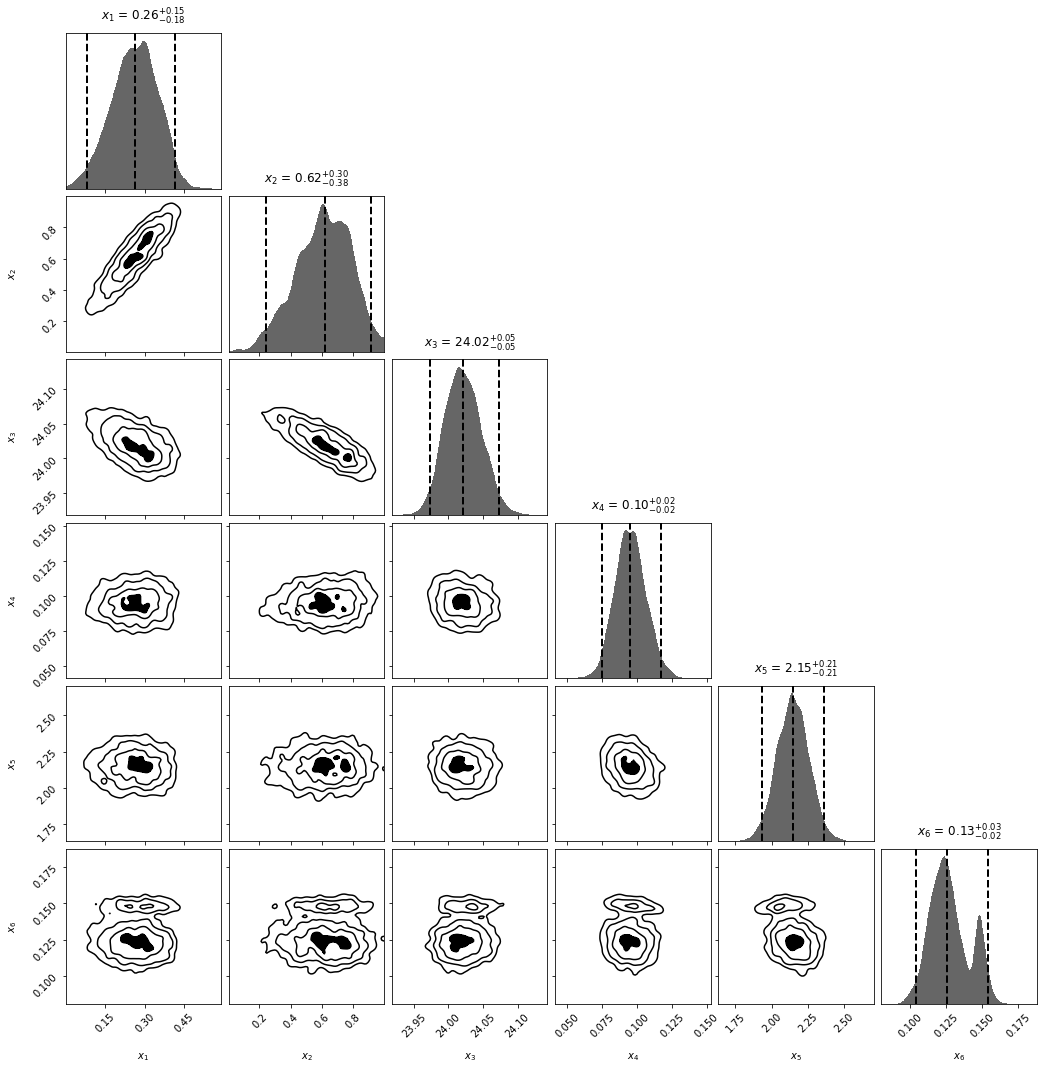

In [21]:
fig, axes = dyplot.cornerplot(results,  show_titles=True, 
                              title_kwargs={'y': 1.04},
                              fig=plt.subplots(6, 6, figsize=(15, 15)))

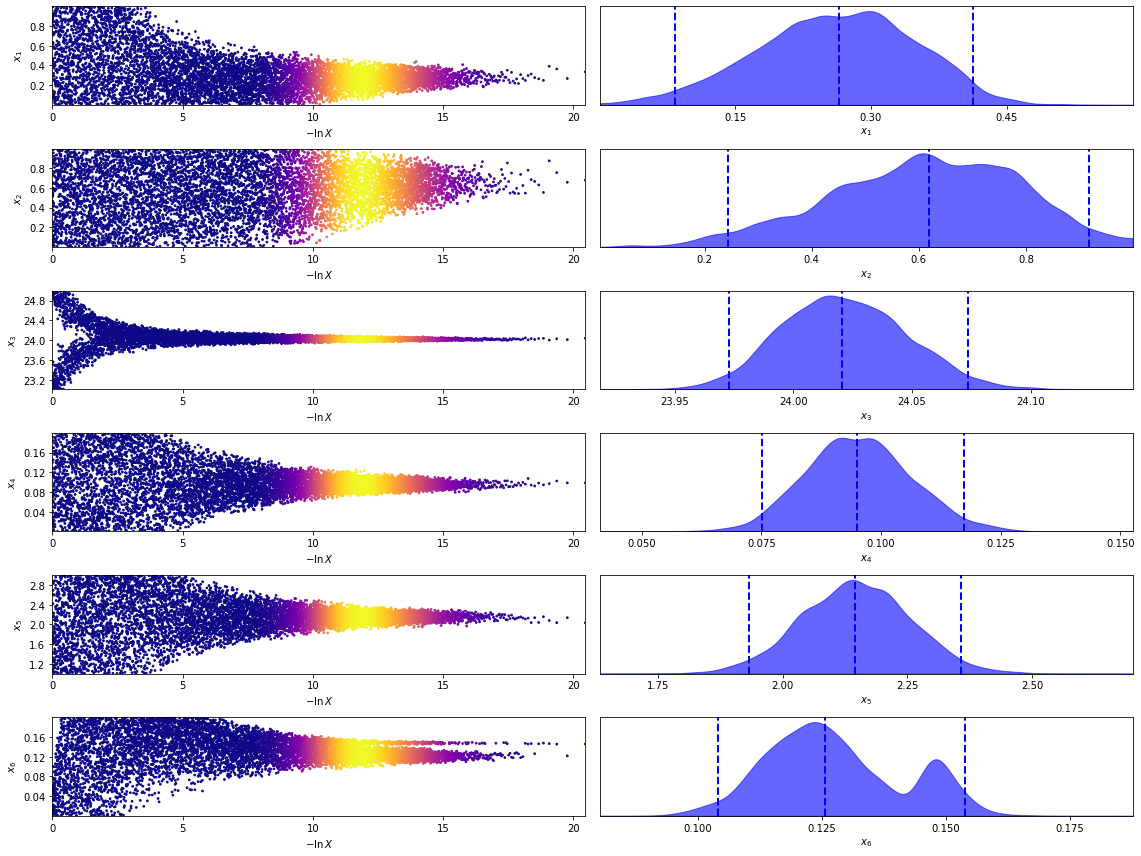

In [22]:
fig, axes = dyplot.traceplot(results,
                             fig=plt.subplots(6, 2, figsize=(16, 12)))
fig.tight_layout()



## Fits SALT2 $\chi^2$ approach after iterative process

In [9]:
cosmo_salt2.log_probability_salt2_chi2_fix([0.3,0.7,24.,0.15,3.])

-207.68471809845528

In [10]:
pos = np.array([0.3,0.7,24.,0.1,3.])+0.01 *np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [11]:
with Pool() as pool:
    sampler_salt2_chi2_fix = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_chi2_fix, pool=pool)
    sampler_salt2_chi2_fix.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [04:21<00:00, 19.14it/s]


#### Chains SALT2

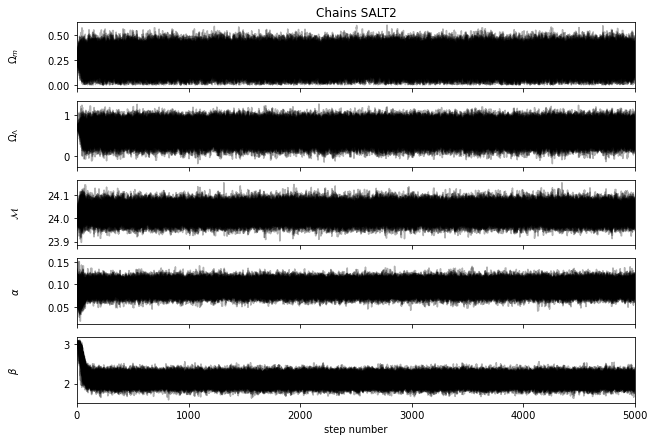

In [12]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_chi2_fix = sampler_salt2_chi2_fix.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_chi2_fix[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_chi2_fix))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [13]:
flat_samples_salt2_chi2_fix = sampler_salt2_chi2_fix.get_chain(discard=2000, thin=15, flat=True) # oq esse thin significa?

In [14]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta"]
names_gdist = ["Om","Ol","M","a","b"]
samples_salt2_chi2_fix = MCSamples(samples=flat_samples_salt2_chi2_fix, names=names_gdist, labels=labels_gdist, label=r'$\chi^2$ (iterative process)')

Removed no burn in


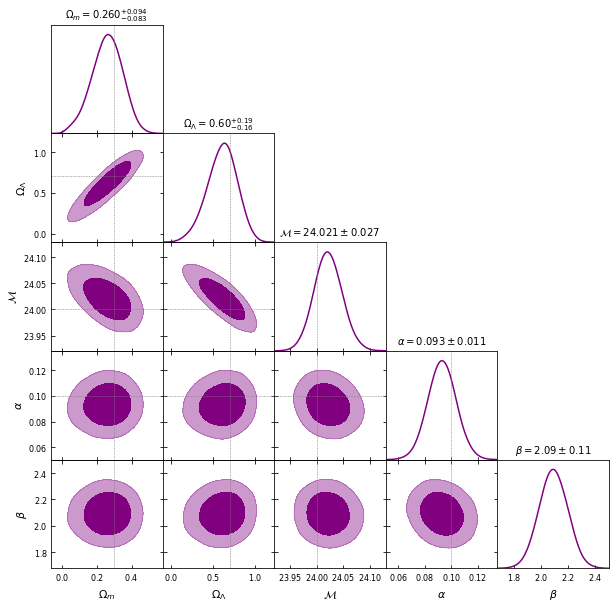

In [15]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot(samples_salt2_chi2_fix, filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':3.})

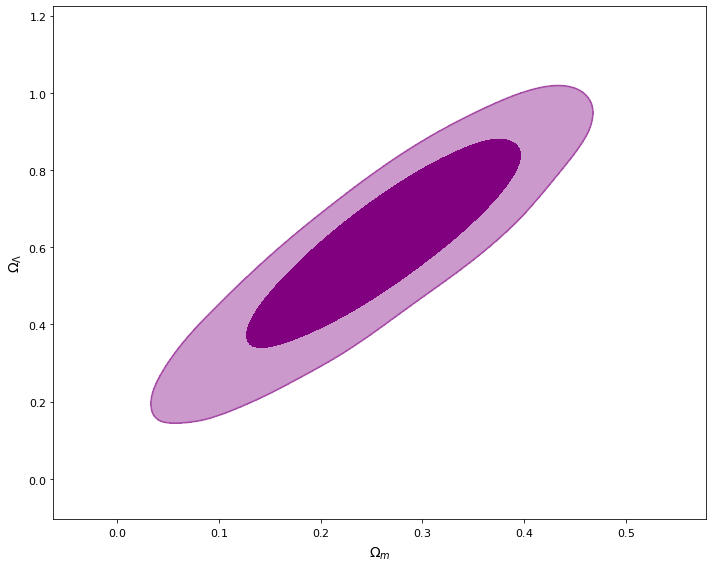

In [16]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2_chi2_fix], 'Om', 'Ol', filled=True, colors=['purple']);

## Fits SALT2 $\chi^2$ approach with only $\sigma_{int}$ fixed at 0.16

In [17]:
cosmo_salt2.log_probability_salt2_chi2_par([0.3,0.7,24.,0.15,3.])

-122.89183760985361

In [18]:
pos = np.array([0.3,0.7,24.,0.1,3.])+0.01 *np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [19]:
moves=emcee.moves.StretchMove(a=1.7)

In [20]:
with Pool() as pool:
    sampler_salt2_chi2_par = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_chi2_par, moves=moves, pool=pool)
    sampler_salt2_chi2_par.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [04:35<00:00, 18.13it/s]


#### Chains SALT2

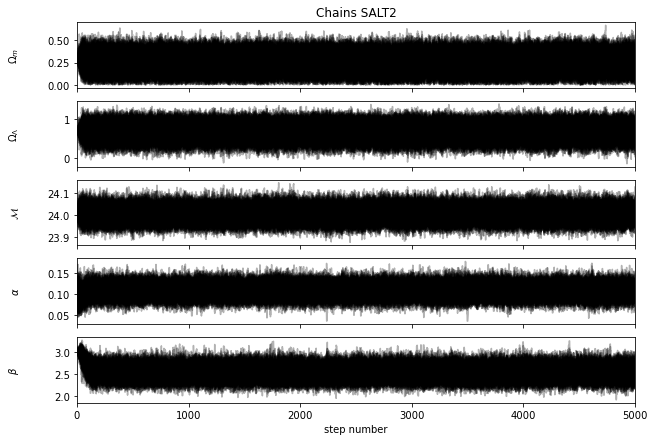

In [21]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_chi2_par = sampler_salt2_chi2_par.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_chi2_par[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_chi2_par))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [22]:
flat_samples_salt2_chi2_par = sampler_salt2_chi2_par.get_chain(discard=2000, thin=15, flat=True) # oq esse thin significa?

In [23]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta"]
names_gdist = ["Om","Ol","M","a","b"]
samples_salt2_chi2_par = MCSamples(samples=flat_samples_salt2_chi2_par, names=names_gdist, labels=labels_gdist, label=r'$\chi^2, \sigma_{int}=0.16$')

Removed no burn in


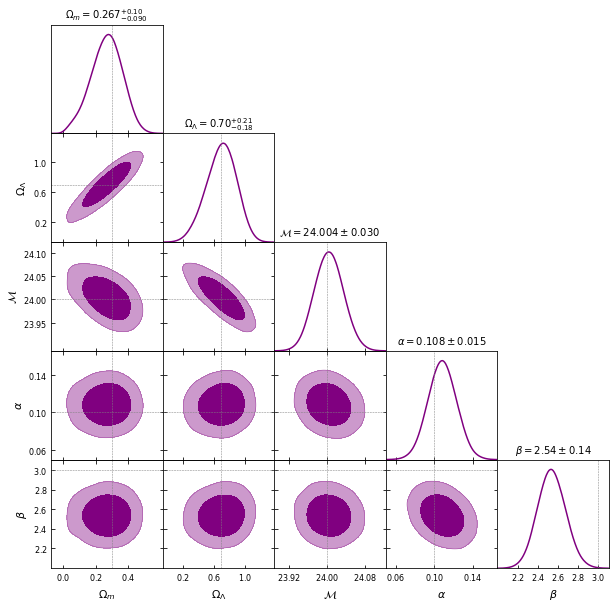

In [24]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot(samples_salt2_chi2_par, filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':3.})

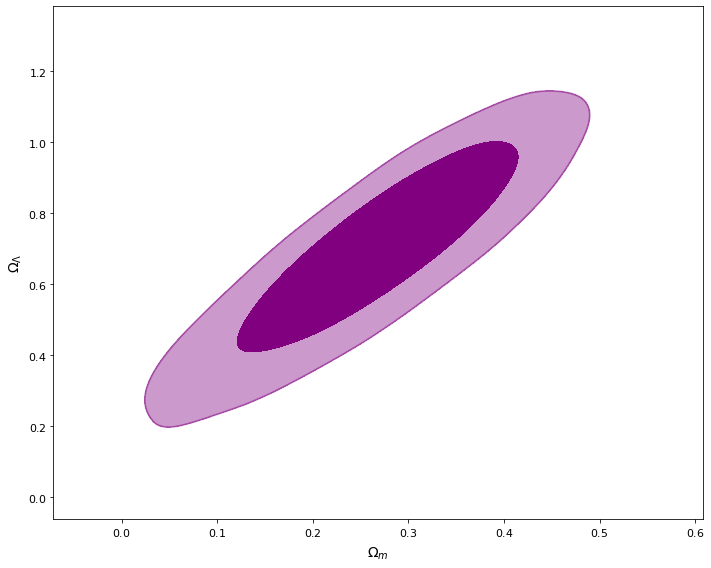

In [25]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2_chi2_par], 'Om', 'Ol', filled=True, colors=['purple']);

## Fits SALT2 $\mathcal{L}$ approacch with $\sigma_{int}$ as free parameter

In [10]:
cosmo_salt2.log_probability_salt2_like_sig_par([0.3,0.6,24.,0.1,2.5,0.12])

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


53.64894728732902

In [11]:
pos = np.array([0.3,0.6,24.,0.1,2.,0.12])+0.01 *np.random.randn(200, 6)
nwalkers, ndim = pos.shape

In [12]:
#moves=emcee.moves.GaussianMove(cov=0.000005)

In [13]:
with Pool() as pool:
    sampler_salt2_like_sig_par = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_like_sig_par, pool=pool)
    sampler_salt2_like_sig_par.run_mcmc(pos, 1000, progress=True)

100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.33it/s]


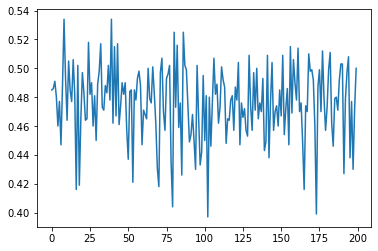

In [14]:
plt.plot(sampler_salt2_like_sig_par.acceptance_fraction)

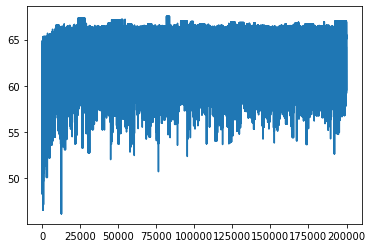

In [15]:
plt.plot(sampler_salt2_like_sig_par.get_log_prob(flat=True))

In [16]:
sampler_salt2_like_sig_par.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [44.99789567 43.25010254 43.1052184  45.02317984 48.11373183 50.5377373 ]

#### Chains SALT2

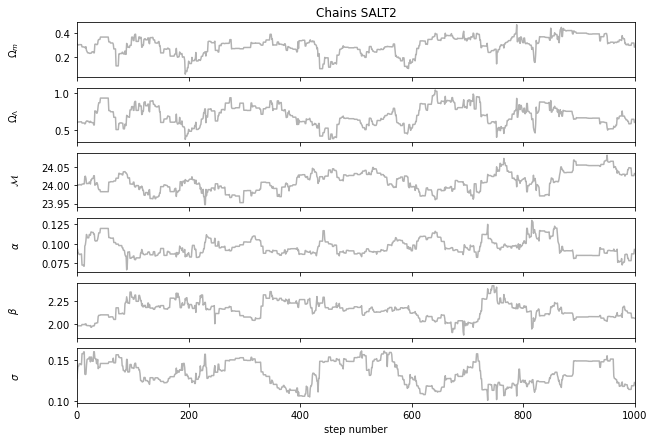

In [17]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_like_sig_par = sampler_salt2_like_sig_par.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_like_sig_par[:, 90, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_like_sig_par))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [18]:
flat_samples_salt2_like_sig_par = sampler_salt2_like_sig_par.get_chain(discard=100, thin=15, flat=True) # oq esse thin significa?

In [19]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta",r"\sigma"]
names_gdist = ["Om","Ol","M","a","b","sig"]
samples_salt2_like_sig_par = MCSamples(samples=flat_samples_salt2_like_sig_par, names=names_gdist, labels=labels_gdist, label=r'$\mathcal{L}, \sigma_{int}$ float')

Removed no burn in


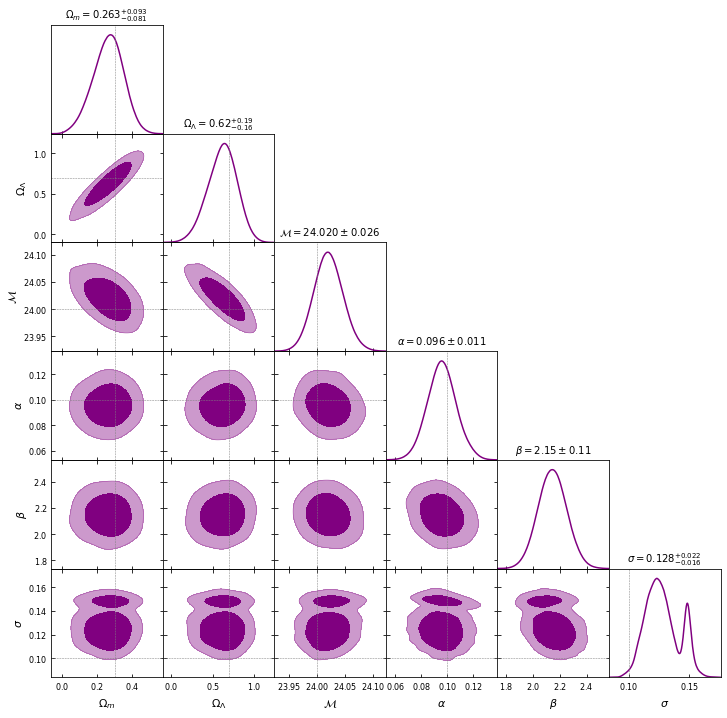

In [20]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot([samples_salt2_like_sig_par], filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':3.,'sig':0.1})

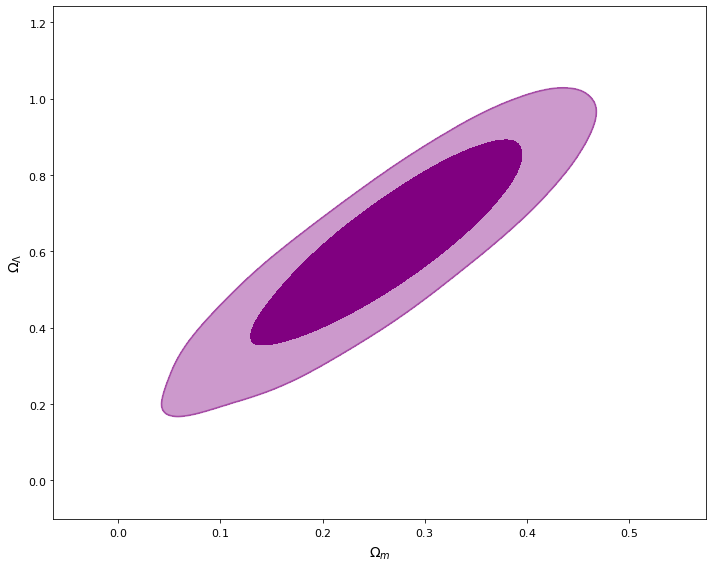

In [21]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2_like_sig_par], 'Om', 'Ol', filled=True, colors=['purple']);

## Fits SALT2 $\mathcal{L}$ approach with $\sigma_{int}$ fixed at 0.16

In [33]:
cosmo_salt2.log_probability_salt2_like_sig_fix([0.3,0.7,24.,0.15,3.])

15.491272301631291

In [34]:
pos = np.array([0.3,0.7,24.,0.1,3.])+0.01 *np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [35]:
with Pool() as pool:
    sampler_salt2_like_sig_fix = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_like_sig_fix, pool=pool)
    sampler_salt2_like_sig_fix.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.66it/s]


#### Chains SALT2

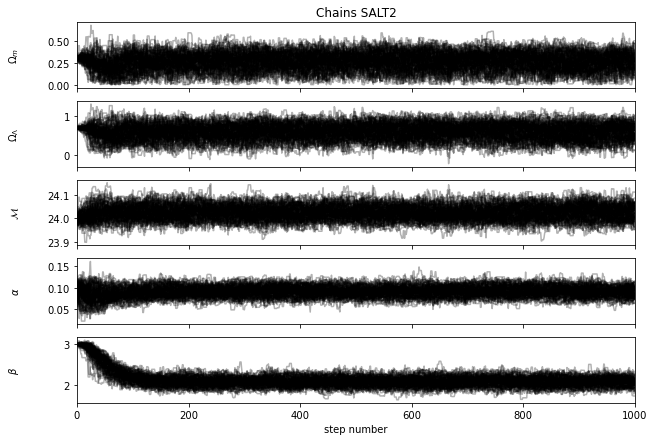

In [36]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_like_sig_fix = sampler_salt2_like_sig_fix.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_like_sig_fix[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_like_sig_fix))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [38]:
flat_samples_salt2_like_sig_fix = sampler_salt2_like_sig_fix.get_chain(discard=2000, thin=15, flat=True) # oq esse thin significa?

In [39]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta"]
names_gdist = ["Om","Ol","M","a","b"]
samples_salt2_like_sig_fix = MCSamples(samples=flat_samples_salt2_like_sig_fix, names=names_gdist, labels=labels_gdist, label=r'$\mathcal{L}, \sigma_{int}=0.16$')

Removed no burn in


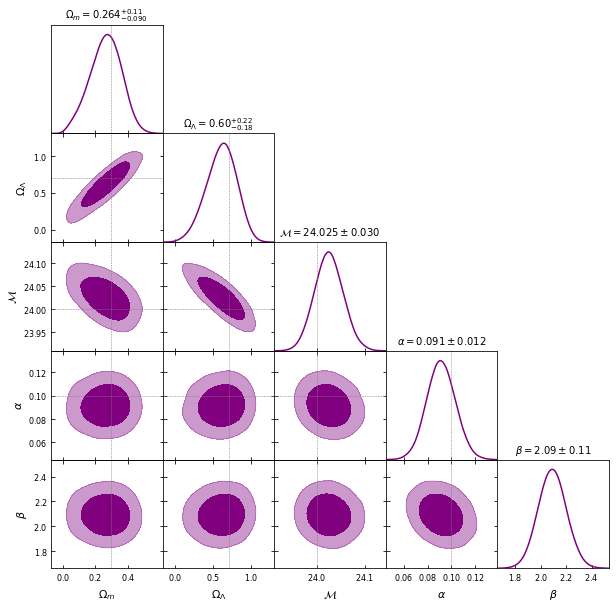

In [40]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot([samples_salt2_like_sig_fix], filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':3.})

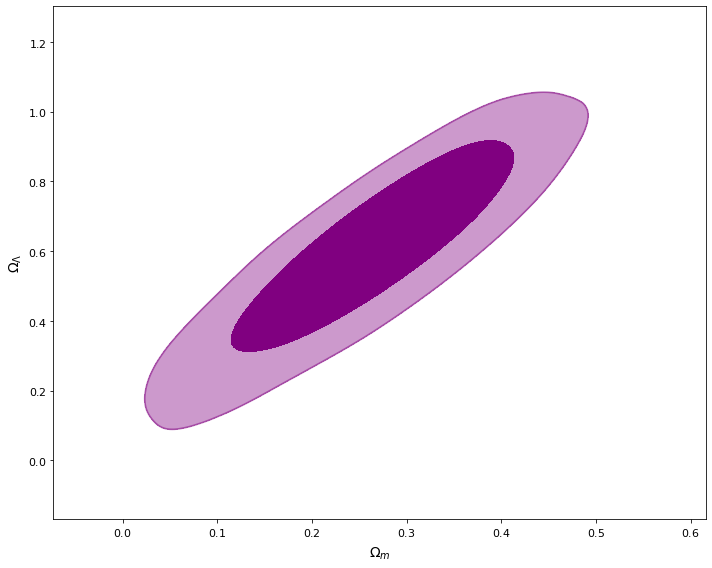

In [41]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2_like_sig_fix], 'Om', 'Ol', filled=True, colors=['purple']);

## Comparison plots

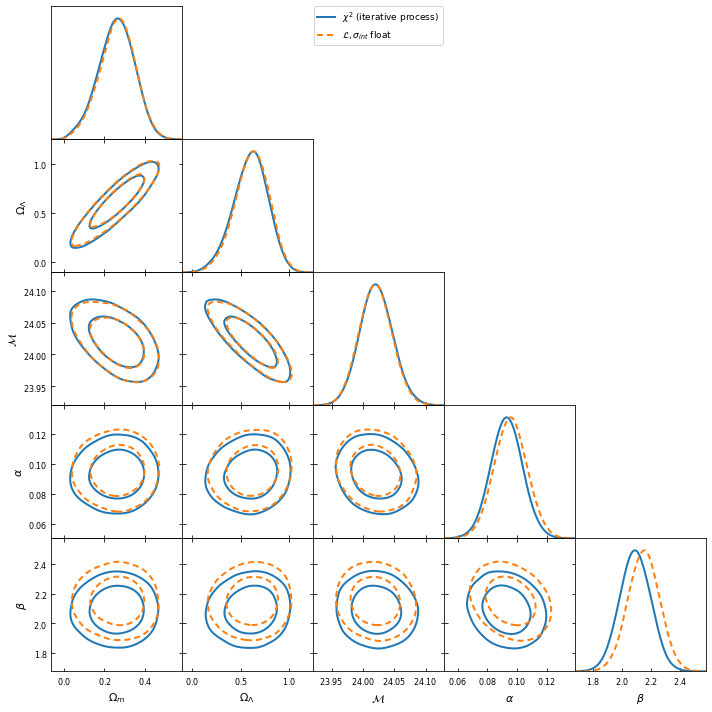

In [42]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([samples_salt2_chi2_fix,samples_salt2_like_sig_par],contour_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}], filled=False)
g.export("triangle_plot.pdf");

<Figure size 864x648 with 0 Axes>

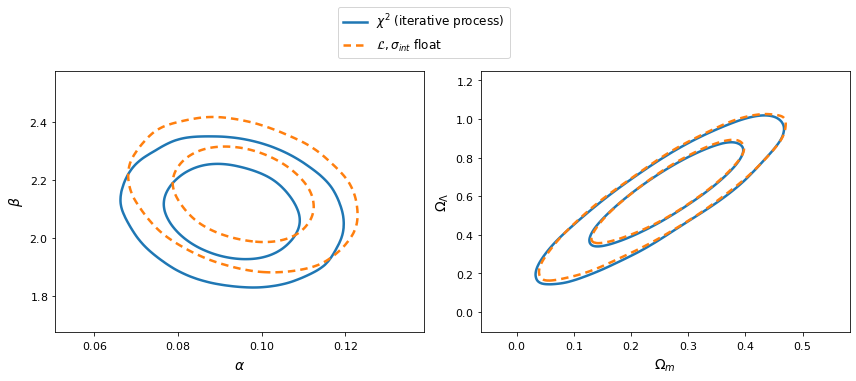

In [43]:
g = plots.get_single_plotter(width_inch=12)
g.plots_2d([samples_salt2_chi2_fix,samples_salt2_like_sig_par],param_pairs=[['a', 'b'], ['Om', 'Ol']], nx=2,contour_args=[{'lw':2.5,'color':'C0'},{'lw':2.5,'ls':'--','color':'C1'}],filled=False)
g.export("like_chi2_comparison.pdf");

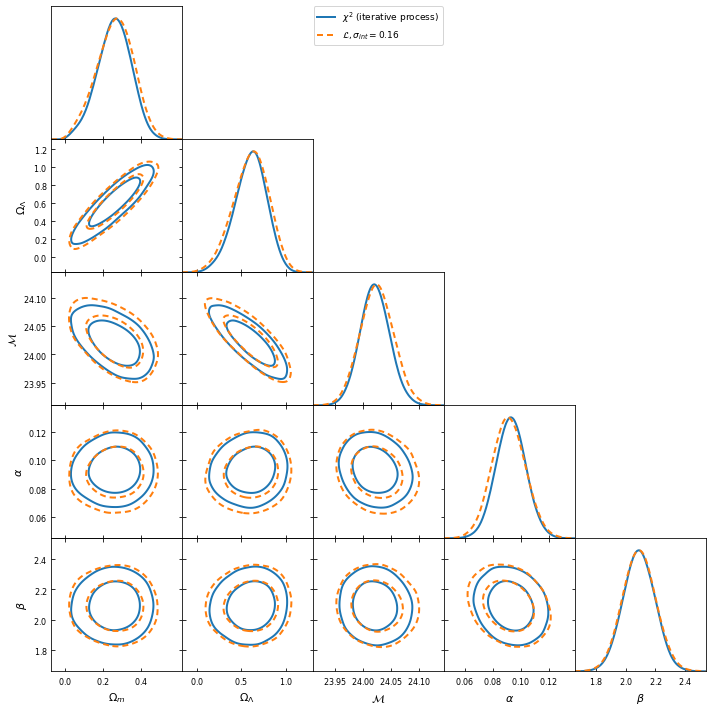

In [44]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([samples_salt2_chi2_fix,samples_salt2_like_sig_fix],contour_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}], filled=False);

<Figure size 864x648 with 0 Axes>

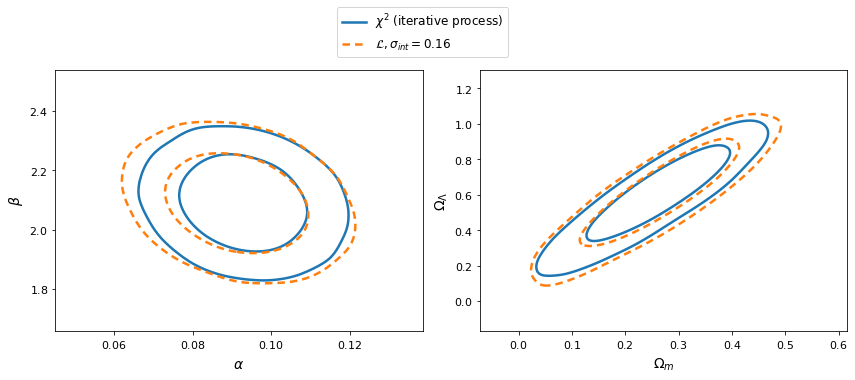

In [45]:
g = plots.get_single_plotter(width_inch=12)
g.plots_2d([samples_salt2_chi2_fix,samples_salt2_like_sig_fix],param_pairs=[['a', 'b'], ['Om', 'Ol']], nx=2,contour_args=[{'lw':2.5,'color':'C0'},{'lw':2.5,'ls':'--','color':'C1'}],filled=False);

## 1-d marginalized plots comparison for $\mathcal{L}$ and $\chi^2$ approaches

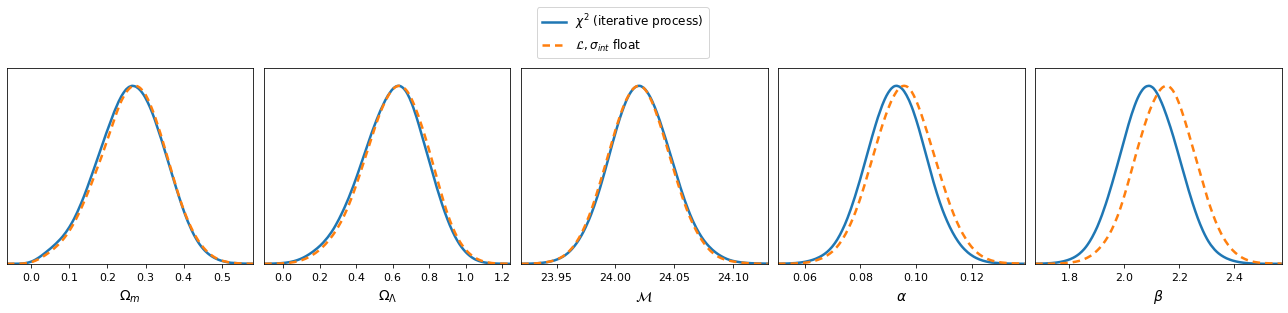

In [46]:
g = plots.get_subplot_plotter(width_inch=18)
g.plots_1d([samples_salt2_chi2_fix,samples_salt2_like_sig_par],['Om','Ol','M','a','b'],line_args=[{'lw':2.5,'color':'C0'},{'lw':2.5,'color':'C1','ls':'--'}],nx=5)
g.export("like_chi2_comparison_1d_1.pdf");

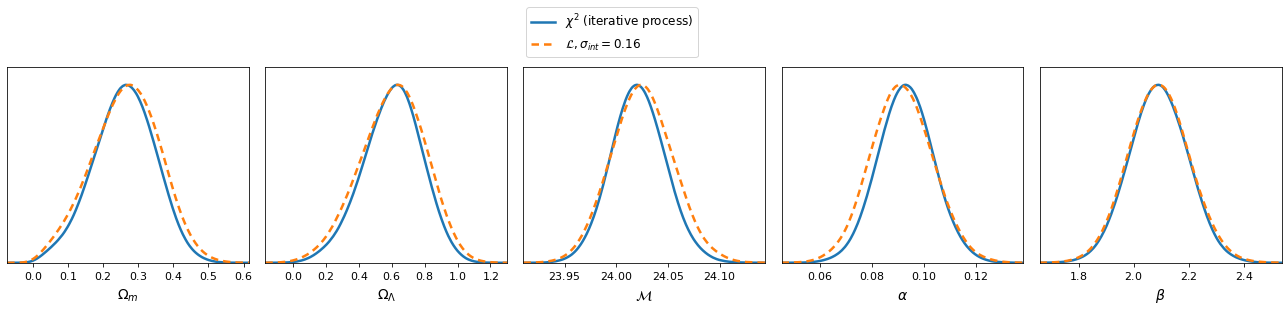

In [47]:
g = plots.get_subplot_plotter(width_inch=18)
g.plots_1d([samples_salt2_chi2_fix,samples_salt2_like_sig_fix],['Om','Ol','M','a','b'],line_args=[{'lw':2.5,'color':'C0'},{'lw':2.5,'color':'C1','ls':'--'}],nx=5);
g.export("like_chi2_comparison_1d_2.pdf");

## Only $\mathcal{L}$ approach

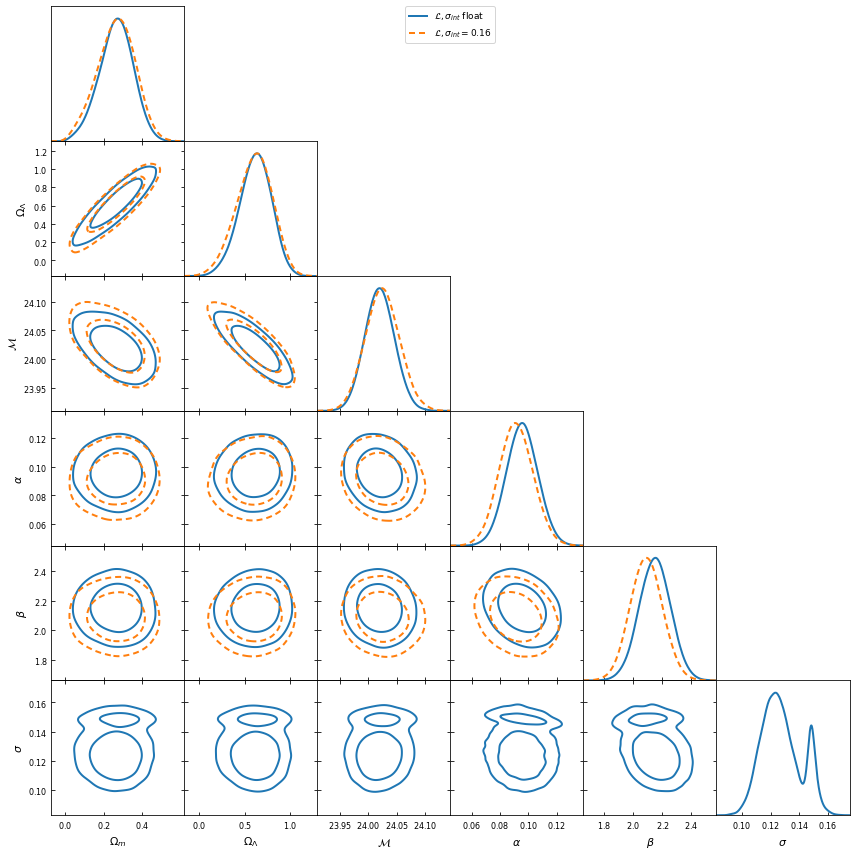

In [48]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([samples_salt2_like_sig_par,samples_salt2_like_sig_fix],contour_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}], filled=False)
g.export("like_triangle.pdf");

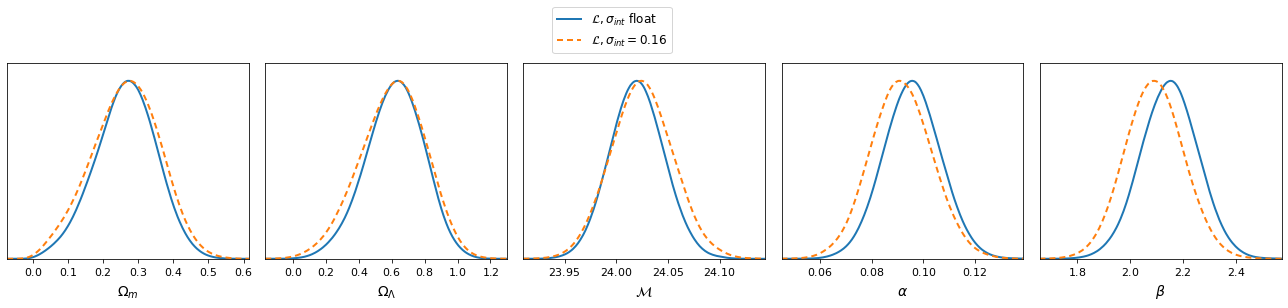

In [49]:
g = plots.get_subplot_plotter(width_inch=18)
g.plots_1d([samples_salt2_like_sig_par,samples_salt2_like_sig_fix],['Om','Ol','M','a','b'],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],nx=5)
g.export("like_comparison_1d.pdf");

## Only $\chi^2$ approach

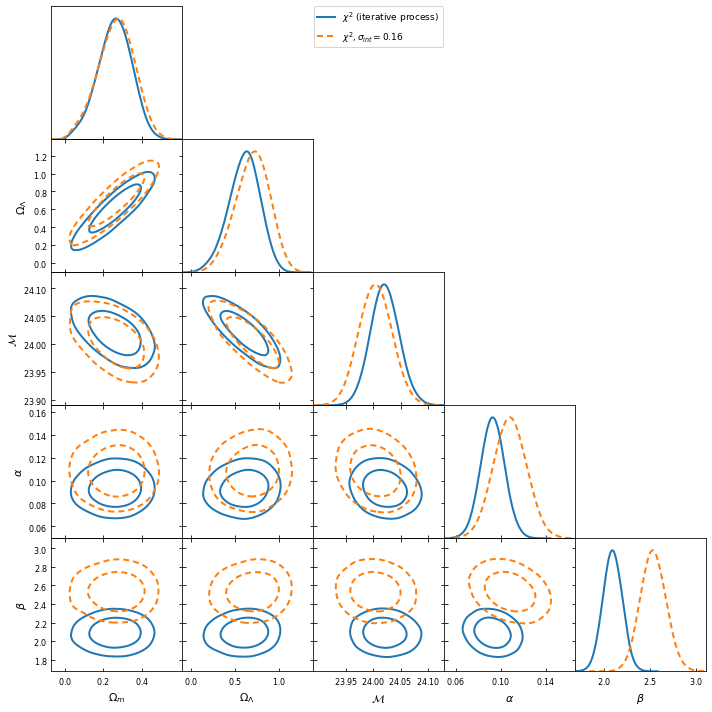

In [50]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([samples_salt2_chi2_fix,samples_salt2_chi2_par], filled=False,contour_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}])
g.export("chi2_triangle.pdf");

<Figure size 1080x810 with 0 Axes>

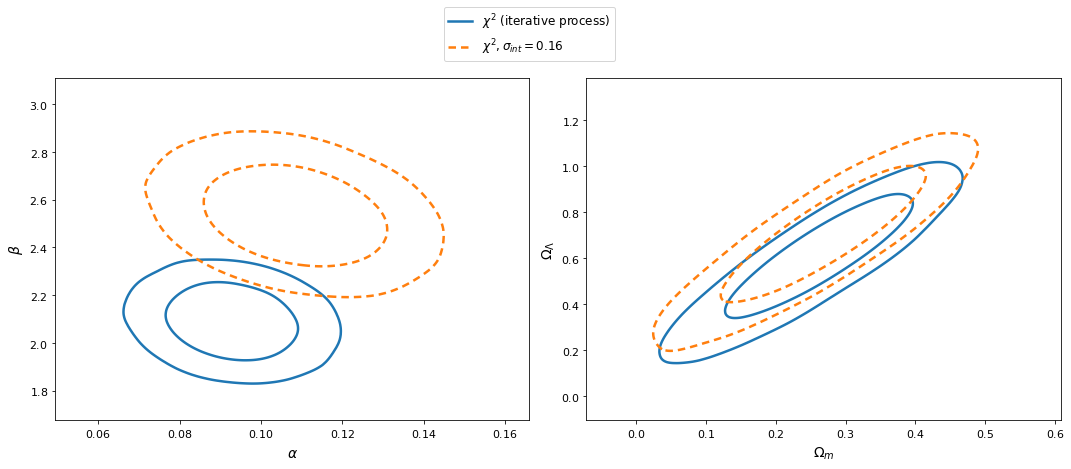

In [51]:
g = plots.get_single_plotter(width_inch=15)
g.plots_2d([samples_salt2_chi2_fix,samples_salt2_chi2_par],param_pairs=[['a', 'b'], ['Om', 'Ol']], nx=2,contour_args=[{'lw':2.5,'color':'C0'},{'lw':2.5,'ls':'--','color':'C1'}],filled=False);

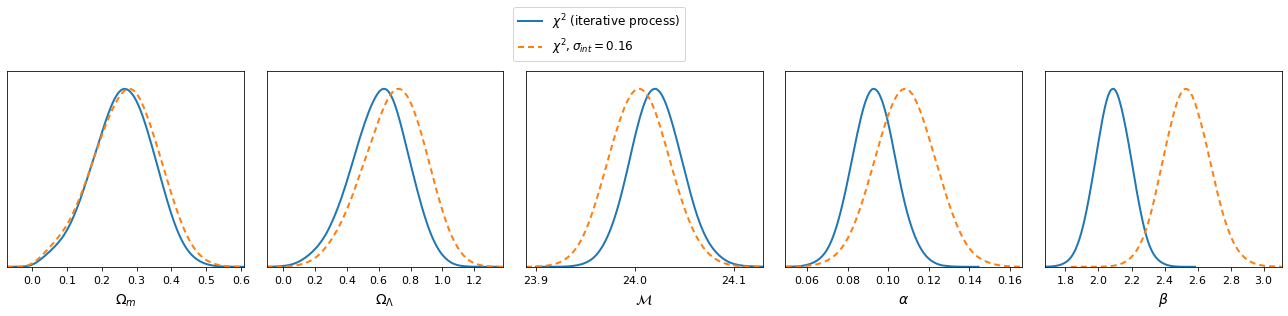

In [52]:
g = plots.get_subplot_plotter(width_inch=18)
g.plots_1d([samples_salt2_chi2_fix,samples_salt2_chi2_par],['Om','Ol','M','a','b'],line_args=[{'lw':2.,'color':'C0'},{'lw':2.,'ls':'--','color':'C1'}],nx=5)
g.export("chi2_comparison_1d.pdf");